Aline Freire de Rezende<br>116110571

Falta corrigir a interseção dos triângulos

# Python imports

In [28]:
import numpy as np
import scipy as sp
from google.colab.patches import cv2_imshow
from google.colab import files
from matplotlib import patheffects
import matplotlib.pyplot as plt
import json

## JSON upload

In [60]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  f = open(fn, )
  graphic_data = json.load(f)
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving xform_mixed.json to xform_mixed (3).json
User uploaded file "xform_mixed.json" with length 905 bytes


# Code (inside test and Screen class)

In [82]:
# TRIANGULARIZAÇÃO DO CÍRCULO

def circleTriangulation(circle):
  '''Executa a triangularização de um círculo
  
  Args:
    circle: primitiva, sendo ela um círculo
  Returns:
    triangles (list): lista com os vértices dos triângulos
  '''

  triangles = []
  points = []
  slices = 20

  for i in range(slices):
    # somei ao centro pois o círculo não está necessariamente centrado na origem
    # centro + ((2πR * fatia)/(total de fatias))
    x = circle["center"][0] + (circle["radius"] * np.cos((2 * np.pi * i) / slices))
    y = circle["center"][1] + (circle["radius"] * np.sin((2 * np.pi * i) / slices)) 
    point = [x, y]
    points.append(point)

  for i in range(slices):
    A = circle["center"].copy()     # centro
    B = points[i].copy()            # ponto i na circunferência
    C = points[(i+1)%slices].copy() # ponto i+1 na circuferência (ao fechar o comprimento, novamente o primeiro ponto)
    triangles.append([A, B, C])

  return triangles

In [81]:
# TRANSFORMAÇÃO AFIM

def circleTransformation(primitive):
  '''Aplica a transformação afim nos triângulos obtidos na triangularização do círculo'''

  transTri = []

  for triangle in primitive["triangulation"]:
    dic = {} # dicionário criado para atender o argumento da função "transformation()" já existente
    dic["xform"] = primitive["xform"]
    dic["vertices"] = triangle
    transformation(dic)
    transTri.append(dic["transVertices"]) # nova chave para indicar os vértices transformados de cada triângulo

  primitive["transTriangles"] = transTri

  return  

# ----------------- 

def transformation(primitive):
  '''Aplica a transformação afim em polígonos'''

  transMatrix = primitive["xform"]
  vertices = primitive["vertices"].copy()
  trans = []

  for vertice in vertices: # aplicação da transformação afim
    x = vertice[0]
    y = vertice[1]
    xNew = transMatrix[0][0] * x + transMatrix[0][1] * y + transMatrix[0][2] * 1
    yNew = transMatrix[1][0] * x + transMatrix[1][1] * y + transMatrix[1][2] * 1
    xNew = int(xNew)
    yNew = int(yNew)
    trans.append([xNew, yNew])
  
  primitive["transVertices"] = trans # nova chave para indicar os vértices transformados

  return

In [80]:
# CRIAÇÃO DA BOUNDING BOX

def bBoxMultTriangles(primitive):
  '''Encontra a bounding box para uma coleção de triângulos resultantes da triangularização de um círculo transformado
  
  Returns:
    xMin, xMax, yMin, yMax (int): delimitações inferiores e superiores de cada coordenada
  '''
  x = y = []

  #salva todos os x e y de todos os triângulos em suas respectivas listas
  for triangle in primitive["transTriangles"]:
    for vertice in triangle:
      x.append(int(vertice[0]))
      y.append(int(vertice[1]))

  # encontra os maiores e menores x's e y's
  xMin = min(x)
  xMax = max(x)
  yMin = min(y)
  yMax = max(y)

  return xMin, xMax, yMin, yMax

# ----------------- 

def boundingBox(primitive): # consiste em pegar os maiores e menores x's e y's
  '''Encontra a bounding box para polígonos por meio dos novos vértices, e para círculos por meio do centro e do raio
  
  Returns:
    ([xMin, xMax], [yMin, yMax]) (tuple): delimitações inferiores e superiores de cada coordenada, já em formato de pontos
  '''
  
  if (primitive["shape"] == "circle"):
    if "xform" in primitive:
      xMin, xMax, yMin, yMax = bBoxMultTriangles(primitive)        
      
    else:
      center = primitive["center"]
      radius = primitive["radius"]

      # encontra os maiores e menores x's e y's somando/diminuindo o raio ao/do centro do círculo
      xMin = center[0] - radius
      xMax = center[0] + radius
      yMin = center[1] - radius
      yMax = center[1] + radius

  else: # caso dos polígonos
    if "xform" in primitive:
      points = primitive["transVertices"].copy()
    else:
      points = primitive["vertices"].copy()

    # encontra os maiores e menores x's e y's
    xMin = min(vertice[0] for vertice in points)
    xMax = max(vertice[0] for vertice in points)
    yMin = min(vertice[1] for vertice in points)
    yMax = max(vertice[1] for vertice in points)

  return ([xMin, xMax], [yMin, yMax])

In [83]:
# CHECAGEM DO PONTO DENTRO DA PRIMITIVA

def buildsVector(pointA, pointB):
  ''' Constrói um vetor a partir de dois pontos A e B

    Args:
      point A (list): Lista com um ponto (coordenadas x e y)
      point B (list): Lista com um ponto (coordenadas x e y)

    Returns:
      vector (array): Vetor a partir dos pontos A e B
    '''
  vector = np.zeros(2, int)

  iA = pointA[0]
  jA = pointA[1]
  iB = pointB[0]
  jB = pointB[1]

  # Cálculo do vetor separado por coordenadas por meio da conta: AB = B - A
  vector[0] = iB-iA
  vector[1] = jB-jA

  return vector
  
# -----------------

def findNormal(vector):
  ''' Calcula o vetor normal a um vetor

    Args:
      vector (array): Vetor de um vértice a outro

    Returns:
      normal (array): Vetor normal a partir do vetor original
    '''
  normal = np.zeros(2, int)
  
  i = vector[0]
  j = vector[1]
  
  # rotação anti-horária
  normal[0] = -j
  normal[1] = i

  return normal

# -----------------  

def insidePolygon(x, y, vertices): # para rotação no sentido anti-horário
  '''Checa se o ponto (x,y) está dentro do polígono convexo.
  
  Args:
    x (float): horizontal point position
    y (float): vertical point position
    vertices (list): lista de vértices do polígono
  Returns:
    False se (x,y) não está dentro do polígono, True caso contrário
  '''

  #inicialização de variáveis
  vectors = [] #lista que vai conter vetores originais do polígono
  vectorsToPoint = [] #lista que vai conter vetores dos vértices originais ao ponto desejado
  normals = [] #lista que vai conter vetores normais aos vetores originais do polígono
  alfas = [] #lista que vai conter o resultado do produto interno entre vetores originais e vetores com o ponto desejado
  
  # Ajustando o ponto
  p = [x,y]

  for i in range(len(vertices)):
    # Construindo os vetores do polígono
    # combina vertices (1, 2), (2, 3), ..., (n-1, n), (n, 1)
    vectors.append(buildsVector(vertices[i], vertices[(i+1)%len(vertices)]))

    # Construindo os vetores de cada vértice ao ponto
    # combina vertices (1, p), (2, p), ..., (n, p)
    vectorsToPoint.append(buildsVector(vertices[i], p))

  # Encontrando as normais aos vetores do triângulo
  for vector in vectors:
    normals.append(findNormal(vector))

  # Produto interno das normais de cada vetor do triângulo com os vetores dos vértices aos pontos
  for i in range(len(normals)):
    alfas.append(normals[i] @ vectorsToPoint[i])
    # exemplo: alfaAB = nAB @ Ap

  # Se todos os alfas forem positivos, sinal de que o ângulo é agudo e o ponto está dentro do triângulo
  for alfa in alfas:
    if (alfa < 0):
      return False

  return True

  # -----------------  

def inside(x, y, primitive):
  """
  Check if point (x,y) is inside the primitive
  
  Args:
    x (float): horizontal point position
    y (float): vertical point position
  Returns:
    True if (x,y) is inside the primitive, False case contrary
  """
  
  # You should implement your inside test here for all shapes   
  # for now, it only returns a false test

  if "xform" in primitive:

    # se for um círculo transformado
    if (primitive["shape"] == "circle"):
      for triangle in primitive["transTriangles"]:
        if (insidePolygon(x, y, triangle) == True):
          return True
      return False  

    # se for um polígono transformado  
    else:
      if (insidePolygon(x, y, primitive["transVertices"]) == True):
        return True
      return False


  # se for um círculo sem transformação
  if (primitive["shape"] == "circle"):
    for triangle in primitive["triangulation"]:
      if (insidePolygon(x, y, triangle) == True):
        return True

  # se for um polígono sem transformação
  else:
    vertices = primitive["vertices"].copy()
    if (insidePolygon(x, y, vertices) == True):
      return True
    return False

  return False

In [35]:
class Screen:
  ''' Creates a virtual basic screen

    Args:
        gdata (dict): dictionary containing screen size and scene description
    '''

  def __init__(self, gdata):
    self._width = gdata.get("width")
    self._height = gdata.get("height")
    self._scene = self.preprocess( gdata.get("scene") )
    self.create_image()

  def preprocess(self, scene):
    ''' Se a primitiva for um círculo, ela o triangulariza. 
        Se a primitiva possuir transformação afim, ela a transforma.

    Args:
      scene (dict): Scene containing the graphic primitives

    Returns:
      scene (dict): Scene containing the graphic primitives with additional info
    '''

    # Possible preprocessing with scene primitives, for now we don't change anything
    # You may define bounding boxes, convert shapes, etc
    preprop_scene = []

    for primitive in scene:
      # do some processing
      # for now, only copies each primitive to a new list


      # executa a triangularização do círculo
      if (primitive["shape"] == "circle"):
        triangles = circleTriangulation(primitive)
        primitive["triangulation"] = triangles


      # executa a transformação na primitiva (opções: círculo ou qualquer polígono)
      if "xform" in primitive:
        if (primitive["shape"] == "circle"):
         circleTransformation(primitive)  

        else:
          transformation(primitive)  
      
      preprop_scene.append(primitive)

    return preprop_scene

  def create_image(self):
    ''' Creates image with white background 
    
    Returns 
      image (numpy array): White image with R, G, B channels
    '''

    self._image = 255 * np.ones((self._height, self._width, 3), np.uint8)

  def rasterize(self):
    ''' Rasterize the primitives along the Screen.
        Define uma bounding box para cada primitiva.    
    '''

    for primitive in self._scene:

      # define uma bounding box
      bBox = boundingBox(primitive)

      # não está nos exemplos, mas casos em que a bounding box tenha cordenadas negativas, esse trecho limita ao primeiro quadrante (afinal, não há pixels negativos)
      for j in range(2):
        for i in range(2):
          if bBox[i][j] < 0: bBox[i][j] = 0

    # Loop through all pixels
    # You MUST use bounding boxes in order to speed up this loop
      for w in range(bBox[0][0], bBox[0][1]):
        x = w + 0.5
        for h in range(bBox[1][0], bBox[1][1]):
          y = h + 0.5
          # First, we check if the pixel center is inside the primitive
          if ( inside(x, y, primitive) ):
            im_x, im_y = w, self._height - (h + 1)
            self._image[im_y, im_x] = primitive['color'][::-1]
        

  def show(self, exec_rasterize = False):
    ''' Show the virtual Screen    
    '''

    if (exec_rasterize):
      self.rasterize()
      
    cv2_imshow(self._image)

  

# Virtual Screen 

### Initialization

In [76]:
screen = Screen(graphic_data)

### Rasterization and raster graphic visualization

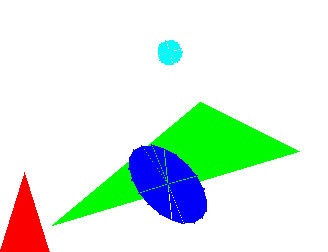

In [77]:
screen.show(True)